In [1]:
import numpy as np
import numpy.linalg as la
import scipy as sp
import scipy.integrate as spint
import matplotlib.pyplot as plt
import unyt as u
from unyt import accepts, returns
import unyt.dimensions as ud

from rocketPy import Quaternion

In [91]:
class SimpleRocket():
    
    def __init__(self):
        
        self.m0 = 40 * u.kg;
        self.c = 2000 * u.m/u.s;
        
        d = 6*u.inch
        self.A_ref = np.pi * d**2/4;
        
        self.ax_roll = np.array([0,0,1])
        self.ax_pitch = np.array([0,1,0])
        self.ax_yaw = np.array([1,0,0])
        
        self.inertia_matrix = np.diag([100,100,10]) * u.kg/u.m**2
        
        self.C_A = 0.5
        self.C_Na = 4
        self.static_margin = 1.5
        
        self.C_D_main_parachute = 0.8
        d_main_parachute = 16*u.ft # 16 ft parachute
        self.A_ref_main_parachute = np.pi*(d_main_parachute/2)**2
        
        self.C_D_drogue_parachute = 0.8
        d_drogue_parachute = 48*u.inch # 48 in parachute
        self.A_ref_drogue_parachute = np.pi*(d_drogue_parachute/2)**2
        
        # location of the cp relative to the cg of the rocket
        self.cp = - (2*(self.A_ref/np.pi)**0.5) * self.static_margin * self.ax_roll
        
        self.thrust_axis = np.array([0.05,0,1])
        #self.thrust_axis = self.thrust_axis/la.norm(self.thrust_axis)
        
        
    @property
    def m0(self): return self._m0*u.kg
    @m0.setter
    @accepts(value=ud.mass)
    def m0(self, value): self._m0 = value.in_base().v
    
    @property
    def c(self): return self._c*u.m/u.s
    @c.setter
    @accepts(value=ud.length/ud.time)
    def c(self, value): self._c = value.in_base().v
        
    @property
    def A_ref(self): return self._A_ref*u.m**2
    @A_ref.setter
    @accepts(value=ud.length**2)
    def A_ref(self, value): self._A_ref = value.in_base().v
        
    @property
    def inertia_matrix(self): return self._inertia_matrix*u.kg/u.m**2
    @inertia_matrix.setter
    @accepts(value=ud.mass/ud.length**2)
    def inertia_matrix(self, value): self._inertia_matrix = value.in_base().v
        
    @property
    def A_ref_main_parachute(self): return self._A_ref_main_parachute*u.m**2
    @A_ref_main_parachute.setter
    @accepts(value=ud.length**2)
    def A_ref_main_parachute(self, value): self._A_ref_main_parachute = value.in_base().v

    @property
    def A_ref_drogue_parachute(self): return self._A_ref_drogue_parachute*u.m**2
    @A_ref_drogue_parachute.setter
    @accepts(value=ud.length**2)
    def A_ref_drogue_parachute(self, value): self._A_ref_drogue_parachute = value.in_base().v
    
    @property
    def cp(self): return self._cp*u.m
    @cp.setter
    @accepts(value=ud.length)
    def cp(self, value): self._cp = value.in_base().v
    
        
        
        
        
        
    # if the function starts with _, then the inputs are assumed to be in si, and the outputs will be in si
    # as floats
    def _dynamics(self, time, state): 
        
        z = state._pos[2]
        pz = state._momentum[2]
        if pz < 0:
            return self._dynamics_descent(time, state)
        else:
            return self._dynamics_ascent(time, state)
        
    #user version
    #@returns((ud.force, ud.force*ud.length, ud.mass/ud.time))
    #def dynamics(self, time, state):   
    #    return self._dynamics(time, state)
        
    def _dynamics_descent(self, time, state):
        
        if state._pos[2] < 500:
            f_drag = self._f_drag_main_parachute(state)
        else:
            f_drag = self._f_drag_drogue_parachute(state)
        
        moments = np.array([0.,0.,0.])
        
        mdot = 0.
        
        return f_drag, moments, mdot
        
    def _dynamics_ascent(self, time, state):
        
        # need to return the forces and moments acting at the cg in body fixed axes.
        # z points towards the nose
        # x points to the right fin
        # y completes right hand coord system
        
        # m_dot is a scalar, negative if the mass is decreasing
        
        # compute thrust force
        f_thrust, m_dot = self._f_thrust(state)
        
        # compute axial drag force
        f_axial = self._f_axial(state)
        
        f_normal = self._f_normal(state)
        
        # sum forces
        # in body axes
        forces = f_thrust + f_axial + f_normal;

        # sum moments
        # in body axes
        moment_f_normal = np.cross(self._cp, f_normal)
        #moment_f_thrust  = np.cross(3*self.cp, f_thrust)
        
        moments = np.array([0.,0.,0.])
        moments += moment_f_normal# + moment_f_thrust
        
        return forces, moments, m_dot
    
    
    def _f_thrust(self, state):
        
        time = state.time
        
        if time < 3:
            f = 4000
        else:
            f = 0
        
        m_dot = -f/self._c
        
        return f*self.thrust_axis, m_dot
        
    def _f_axial(self, state):
        
        q_inf = self._dynamic_pressure(state);
        F_A = q_inf * self.C_A * self._A_ref;
        
        # is aligned with negative z axis
        F_A = np.array([0,0, -F_A]);
        
        return F_A
    
    def _f_drag_main_parachute(self, state):
        
        q_inf = self._dynamic_pressure(state);
        F_A = q_inf * self.C_D_main_parachute * self._A_ref_main_parachute;
        
        # is aligned with airspeed vector
        v_air_B = state.T_BE() @ self._v_air_cp(state)
        
        F_A = F_A * v_air_B/la.norm(v_air_B);
        
        return F_A
    
    def _f_drag_drogue_parachute(self, state):
        
        q_inf = self._dynamic_pressure(state);
        F_A = q_inf * self.C_D_drogue_parachute * self._A_ref_drogue_parachute;
        
        # is aligned with airspeed vector
        v_air_B = state.T_BE() @ self._v_air_cp(state)
        
        F_A = F_A * v_air_B/la.norm(v_air_B);
        
        return F_A
    
    
    def _f_normal(self, state):
        
        C_N = self.C_Na * self._alpha(state)
        
        q_inf = self._dynamic_pressure(state)
        
        F_N = q_inf * C_N * self._A_ref * self.normal(state)
                
        return F_N

    
    ## these are implementation specific
    ## ie as a person designing the rocket, you need to define how you determine the aero forces, 
    ## so you own these equations
    ## the state just interfaces bewteen scipy solve ivp and rocket dynamics
    
        
    def _dynamic_pressure(self, state):
        z = state._pos[2]
        
        # todo update to use the cp velocity
        v_air = self._v_air_cp(state)
        
        dynamic_pressure = 0.5 * state.env._rho(z) * v_air @ v_air
        
        return dynamic_pressure
    
    def _v_body(self, state):
        """Returns the velocity of the body in earth coordinates"""
        
        return state._momentum/state._mass;
    
    def _v_air_cg(self, state):
        """Returns the apparent airspeed at the CG in earth coordinates
        v_air_cg = -v_body + wind
        """
        return -self._v_body(state) + state._wind()
    
    #def v_air_p(self, p):
    #    """Computes the airspeed at some location p.
    #    p is the position vector of the point relative to the cg of the rocket in earth coordinates
    #    """
    #    # todo (high): update with 6DOF
    #    omega = np.array([0,0,0])
    #    # todo convert p to earth coordinates
    #    
    #    return self.v_air_cg(state) + np.cross(omega, p)
        
        
    def _v_air_cp(self, state):
        """Returns the apparent airspeed at the CP
        accounts for the rotation rate of the body
        """
        
        #todo (high): update to account for the rotation rate
        
        return self._v_air_cg(state)
        
    def _alpha(self, state, p=None):
        """Return the angle of attack of the air at some location on the body p (relative to the cg)"""
        
        
        # angle between roll axis and airspeed at p
        # if p is none, use the cp
        
        if p is not None:
            raise NotImplementedError
        
        v_air_cp = self._v_air_cp(state)
        
        # compute unit vector in direction of the airspeed
        v_air_cp_unit = v_air_cp/la.norm(v_air_cp)
        
        # get roll axis in earth coordinates
        neg_roll_axis = -state.T_EB() @ self.ax_roll
        
        # todo (low): remove
        np.testing.assert_almost_equal(la.norm(neg_roll_axis), 1.0)
        
        val = v_air_cp_unit @ neg_roll_axis
        
        val = np.clip(val, -1, 1) # may go every so slightly outside due to numerical issues
        
        alpha = np.arccos(val)
        
        return alpha
  
    
    def normal(self, state):
        """Gets the normal vector direction (direction of lift generation) in Body coordinates"""
        
        # earth axes roll axis
        #roll = self.ax_roll

        # get the airspeed vector in body coords
        v = state.T_BE() @ self._v_air_cp(state)
        
        # convert to unit vector
        vhat = v/la.norm(v)
        
        # compute the normal direction
        n = np.cross(np.cross(self.ax_roll, vhat), self.ax_roll)
        
        # convert to unit vector
        n_hat = n/la.norm(n)
        
        # convert to body axes
        #n_hat = state.T_BE() @ n_hat
        
        return n_hat
    

In [92]:
class Env():
    
    def __init__(self, wind = np.array([0,0,0])):
        
        A  = np.eye(3) + np.random.rand(3,3)*0.1-0.05 # add some noise when initializing the wind
        self._wind = A @ wind
        
        return
    
    def _rho(self, z):
        """ Return the density at some altitude in meters"""
        return 1.225
    
    def _wind_vector(self, time=None, pos=None):
        # time and pos in si units
        
        #if pos[2] > 1000:
        #    return -10*np.array([self.wind[1], self.wind[0], self.wind[2]])
        #else:
            return self._wind

In [93]:
class State():
    
    def __init__(self, time=0*u.s, mass=1*u.kg, position=np.array([0,0,0])*u.m, momentum=np.array([0,0,0])*u.kg*u.m/u.s, quaternion=Quaternion(1,0,0,0), angular_momentum = np.array([0,0,0])*u.kg*u.m**2/u.s, env=Env()):
        
        self.time = time;
        
        self.mass = mass;
        self.pos = position;
        self.momentum = momentum;
        self.quaternion = quaternion #no rotation
        self.angular_momentum = angular_momentum;
        
        self.env = env;
        
    @property
    def time(self): return self._time*u.s
    @time.setter
    @accepts(value=ud.time)
    def time(self, value): self._time = value.in_base().v
    
    @property
    def mass(self): return self._mass*u.kg
    @mass.setter
    @accepts(value=ud.mass)
    def mass(self, value): self._mass = value.in_base().v
        
    @property
    def pos(self): return self._pos*u.m
    @pos.setter
    @accepts(value=ud.length)
    def pos(self, value): self._pos = value.in_base().v
    
    @property
    def momentum(self): return self._momentum*u.kg*u.m/u.s
    @momentum.setter
    @accepts(value=ud.momentum)
    def momentum(self, value): self._momentum = value.in_base().v
        
    @property
    def angular_momentum(self): return self._angular_momentum*u.kg*u.m**2/u.s
    @angular_momentum.setter
    @accepts(value=ud.momentum*ud.length)
    def angular_momentum(self, value): self._angular_momentum = value.in_base().v
    
        
    
    
    def vector(self):
        """Convert state to vector"""
        # passes the quaternion's vector
        
        return np.hstack([[self._mass], self._pos, self._momentum, self.quaternion.q, self._angular_momentum]);
    
    def _update(self,statev, time=None):
        # take a state vector and pass it to the internal objects
        if time is not None:
            self._time = time
            
        self._mass = statev[0]
        self._pos = statev[1:4]
        self._momentum = statev[4:7]
        self.quaternion = Quaternion(*statev[7:11])
        self._angular_momentum = statev[11:14]
        
        return self
        
        
    def _wind(self):
        """Returns the Earth coordinate wind vector at this state"""
        # maybe allow it to take some offset vector?
        # in either Earth or Body axes?
        
        # should be a deterministic function of state
        # for now a constant with time and altitude, blowing to the negative x direction
        return self.env._wind_vector(self._time, self._pos)
    
    
    def T_BE(self):
        """Rotation matrix from Earth axes to Body axes
            Therefore v_B = T_BE() @ v_E
        """
        return self.quaternion.rot_matrix().transpose()
        
        
    def T_EB(self):
        """Rotation matrix from from Body axes to Earth axes
            Therefore v_E = T_EB() @ v_B
        """
        
        return self.quaternion.rot_matrix()
    
    
    def __repr__(self):
        return f'State  {self.vector()}'

In [94]:
class Simulation():
    
    def __init__(self, rocket, state_initial, launch_angle=6*u.degree,launch_length=5*u.m):

        self.rocket = rocket
            
        self.ax_x = np.array([1,0,0])
        self.ax_y = np.array([0,1,0])
        self.ax_z = np.array([0,0,1]) # vertically upwards
        
        self._g0 = 9.81
        self._g  = - self._g0*self.ax_z
        
        self.state = state_initial;
        
        
        
        self._launch_rail_length = launch_length.in_base().v;
        
        self._launch_angle = launch_angle.in_base().v;
        
        self.ax_launch = np.array([np.sin(self._launch_angle), 0, np.cos(self._launch_angle)])
        
        self.state.quaternion = Quaternion.from_angle(self._launch_angle, self.ax_y)
        
    
    def _dynamics(self, time, statev):
        
        #get a state object
        state = self.state._update(statev, time)
        
        # calculate the angular velocity of the rocket
        R = state.quaternion.rot_matrix()
        omega = R @ la.inv(self.rocket._inertia_matrix) @ R.T @ state._angular_momentum;
        # this omega is in earth coordinates, about the cg
        # determine rate of change of quaternion
        d_quaternion = state.quaternion.rate_of_change(omega)
        
        
        # get the rocket axis forces and moments
        forces_b, moments_b, m_dot = self.rocket._dynamics(time, state)
        
        # convert body axis forces into earth axis
        #px, py, pz = state.momentum;
        #th = np.arctan2(px,pz)
        R = state.T_EB() #np.array([[np.cos(th), 0, np.sin(th)],[0,1,0],[-np.sin(th), 0, np.cos(th)]])
        
        # compute forces in earth coords
        forces = R @ forces_b + state._mass*self._g;
        moments = R @ moments_b;
        
        
        # apply launch rail
        # compute v_cg
        V_cg = self.state._momentum/self.state._mass;
        if la.norm(state._pos) < self._launch_rail_length:
            V_cg = self.ax_launch * np.dot(V_cg, self.ax_launch);
            forces = self.ax_launch * np.dot(forces, self.ax_launch);
            moments = np.array([0.,0.,0.]) # no moments during launch rail
        

        # set derivatives
        d_mass = m_dot
        d_pos = V_cg
        d_momentum = forces;
        #d_quaternion = d_quat #set above
        d_angular_momentum = moments;
        
        return np.hstack([d_mass, d_pos, d_momentum, d_quaternion, d_angular_momentum])
    
    
    def solve(self, t_span = [0,100]):
        # set initial state
        s0 = self.state.vector()
        
        # when im no longer at the rail
        def no_rail(t, y):
            pos = la.norm(y[1:4]) - self._launch_rail_length;
            return pos
        no_rail.terminal = False
        no_rail.direction = 1;
        
        def apogee(t, y):
            return y[6]# + 250*y[0] # when the velocity is -10 m/s
        apogee.terminal = False
        apogee.direction = -1;
        
        def landing(t, y):
            return y[3]
        landing.terminal = True
        landing.direction = -1;
        
        self.sim_result = spint.solve_ivp(self._dynamics, t_span, s0, dense_output=True, events=(no_rail, apogee, landing));
        
        self.output = self.sim_result.sol;
        
        return self.sim_result
        
        
    
        

In [95]:
def plot_v_xz(v):
    plt.arrow(0,0,v[0], v[2], length_includes_head=True, width=0.1)

In [96]:
r = SimpleRocket()

In [97]:
#env = Env(wind=np.array([-np.sin(30*np.pi/180),0,-np.cos(30*np.pi/180)]))
env = Env(wind=np.array([10,0,0]))

In [98]:
s0 = State(env = env)
s0.mass = 40*u.kg;
s0.momentum = np.array([0,0,30*s0._mass])*u.kg*u.m/u.s
q = Quaternion.from_angle(0, np.array([0,1,0]))
s0.quaternion = q

In [99]:
q

[1. 0. 0. 0.]

In [100]:
s0

State  [4.0e+01 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.2e+03 1.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]

In [101]:
s0.T_EB() @ r.ax_roll

array([0., 0., 1.])

In [102]:
r._v_body(s0)

array([ 0.,  0., 30.])

In [103]:
r._v_air_cg(s0)

array([ 10.08487341,   0.46953399, -29.6245814 ])

In [104]:
r._alpha(s0)*180/np.pi

18.818660488307728

In [105]:
r.normal(s0)

array([ 0.99891792,  0.04650786, -0.        ])

In [106]:
la.norm(r.normal(s0))

1.0

In [107]:
fn = r._f_normal(s0)
fn

array([14.36297419,  0.66871485, -0.        ])

In [108]:
r.cp

unyt_array([-0.    , -0.    , -0.2286], 'm')

In [109]:
mn_b = np.cross(r.cp, fn)
mn_b

array([ 0.15286821, -3.2833759 ,  0.        ])

In [110]:
mn_b = np.cross(r._cp, fn)
mn_b

array([ 0.15286821, -3.2833759 ,  0.        ])

In [111]:
mn_e = s0.T_EB() @ mn_b
mn_e

array([ 0.15286821, -3.2833759 ,  0.        ])

In [112]:
env = Env(np.array([-5,10,0]))
s1 = State(quaternion=Quaternion(1,0,0,0), env=env)
s1.mass = 40*u.kg
s1
sim = Simulation(r, s1)

In [113]:
sim = Simulation(r, s1)

In [114]:
sim._g

array([-0.  , -0.  , -9.81])

In [115]:
s1

State  [40.          0.          0.          0.          0.          0.
  0.          0.99862953  0.          0.05233596  0.          0.
  0.          0.        ]

In [116]:
r._dynamics(0, sim.state)

(array([ 196.22708119,    7.10942885, 3999.33963491]),
 array([1.62521544, 0.86248924, 0.        ]),
 -2.0)

In [117]:
%time sol = sim.solve(t_span=[0,10*60])

CPU times: user 1.15 s, sys: 84.3 ms, total: 1.24 s
Wall time: 647 ms


In [118]:
sol.message

'A termination event occurred.'

In [119]:
sol.success

True

In [120]:
sol;

In [121]:
sol.t_events

[array([0.33101178]), array([24.86951662]), array([221.18345281])]

Text(0.5, 1.0, 'Alpha')

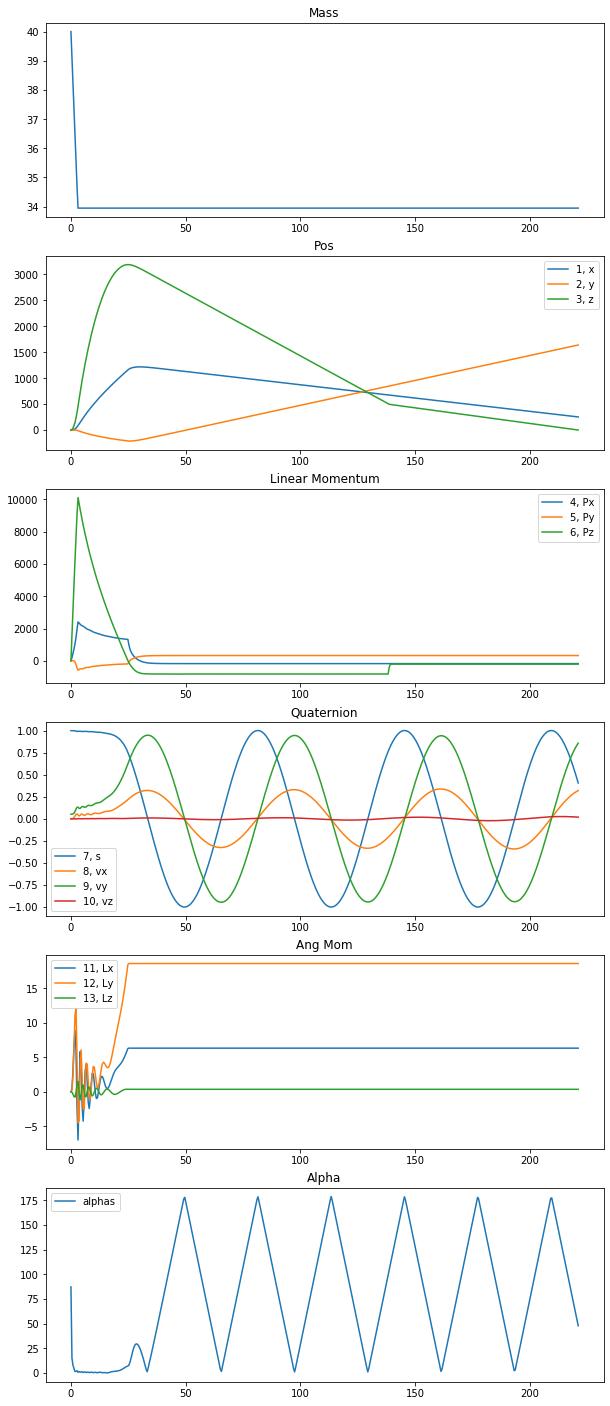

In [124]:
t_eval = np.linspace(sol.t[0], sol.t[-1], 500)


plt.figure(figsize=(10,25))
plt.subplot(611)
plt.plot(t_eval,sol.sol(t_eval)[0])

#for t in sol.t_events:
#    if len(t) is not 0:
#        plt.axvline(t, color='gray',linestyle='--')
    
plt.title('Mass')



plt.subplot(612)
plt.plot(t_eval,sol.sol(t_eval)[1], label='1, x')
plt.plot(t_eval,sol.sol(t_eval)[2], label='2, y')
plt.plot(t_eval,sol.sol(t_eval)[3], label='3, z')
#for t in sol.t_events:
#    plt.axvline(t, color='gray',linestyle='--')
plt.legend()
plt.title('Pos')



plt.subplot(613)
plt.plot(t_eval,sol.sol(t_eval)[4], label='4, Px')
plt.plot(t_eval,sol.sol(t_eval)[5], label='5, Py')
plt.plot(t_eval,sol.sol(t_eval)[6], label='6, Pz')
#for t in sol.t_events:
#    plt.axvline(t, color='gray',linestyle='--')
    
plt.legend()
plt.title('Linear Momentum')



plt.subplot(614)
plt.plot(t_eval,sol.sol(t_eval)[7], label='7, s')
plt.plot(t_eval,sol.sol(t_eval)[8], label='8, vx')
plt.plot(t_eval,sol.sol(t_eval)[9], label='9, vy')
plt.plot(t_eval,sol.sol(t_eval)[10], label='10, vz')
#for t in sol.t_events:
#    plt.axvline(t, color='gray',linestyle='--')
    
plt.legend()
plt.title('Quaternion')



plt.subplot(615)
plt.plot(t_eval,sol.sol(t_eval)[11], label='11, Lx')
plt.plot(t_eval,sol.sol(t_eval)[12], label='12, Ly')
plt.plot(t_eval,sol.sol(t_eval)[13], label='13, Lz')
#for t in sol.t_events:
#    plt.axvline(t, color='gray',linestyle='--')
    
plt.legend()
plt.title('Ang Mom')


plt.subplot(616)
alphas = [r._alpha(s1._update(sol.sol(t), 0))*180/np.pi for t in t_eval]
plt.plot(t_eval,alphas, label='alphas')
#for t in sol.t_events:
#    plt.axvline(t, color='gray',linestyle='--')
    
plt.legend()
plt.title('Alpha')



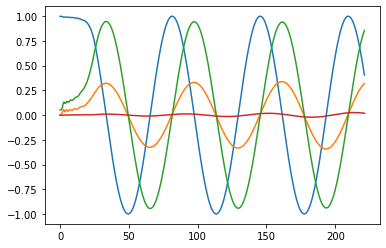

In [125]:
plt.plot(t_eval,sol.sol(t_eval)[7], label='7, s')
plt.plot(t_eval,sol.sol(t_eval)[8], label='8, vx')
plt.plot(t_eval,sol.sol(t_eval)[9], label='9, vy')
plt.plot(t_eval,sol.sol(t_eval)[10], label='10, vz')

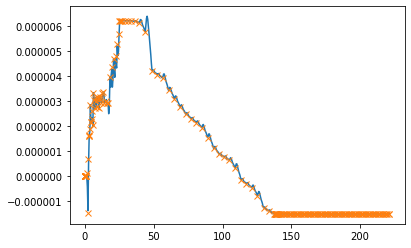

In [126]:
plt.plot(t_eval,[1-la.norm(sol.sol(t)[7:11]) for t in t_eval])
plt.plot(sol.t,[1-la.norm(sol.y[7:11,t]) for t in range(len(sol.t))], 'x')

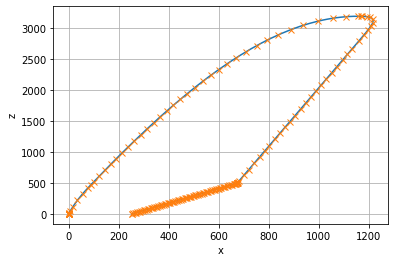

In [127]:
ax = plt.gca()
ax.plot(sol.sol(t_eval)[1], sol.sol(t_eval)[3])
ax.plot(sol.y[1], sol.y[3],'x')

plt.xlabel('x')
plt.ylabel('z')

#ax.set_aspect('equal', 'datalim')
plt.grid()

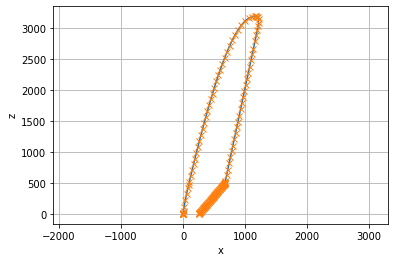

In [128]:
ax = plt.gca()
ax.plot(sol.sol(t_eval)[1], sol.sol(t_eval)[3])
ax.plot(sol.y[1], sol.y[3],'x')

plt.xlabel('x')
plt.ylabel('z')

ax.set_aspect('equal', 'datalim')
plt.grid()

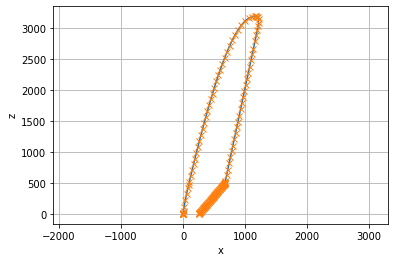

In [129]:
plt.plot(sol.sol(t_eval)[1], sol.sol(t_eval)[3])
plt.plot(sol.y[1], sol.y[3],'x')

plt.xlabel('x')
plt.ylabel('z')

ax = plt.gca()
ax.set_aspect('equal', 'datalim')
plt.grid()

(-3, 5)

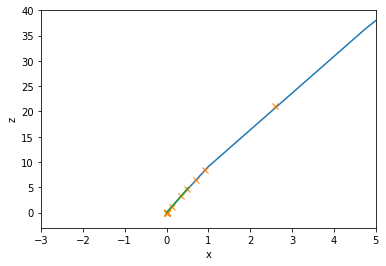

In [131]:
plt.plot(sol.sol(t_eval)[1], sol.sol(t_eval)[3])
plt.plot(sol.y[1], sol.y[3],'x')


plt.xlabel('x')
plt.ylabel('z')


xrail = [0, sim._launch_rail_length*np.sin(sim._launch_angle)]
zrail = [0, sim._launch_rail_length*np.cos(sim._launch_angle)]

xrail2 = [0, 10*sim._launch_rail_length*np.sin(sim._launch_angle)]
zrail2 = [0, 10*sim._launch_rail_length*np.cos(sim._launch_angle)]


plt.plot(xrail, zrail)

plt.ylim(-3,40)
plt.xlim(-3,5)


In [134]:
t_eval;

Text(0.5, 1.0, 'momentum angle')

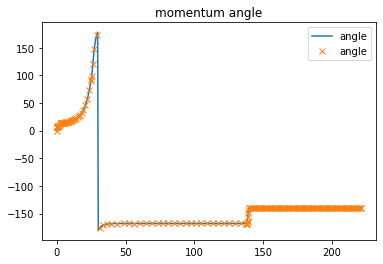

In [135]:
angle = 180*np.arctan2(sol.sol(t_eval)[4], sol.sol(t_eval)[6])/np.pi
angle_m = 180*np.arctan2(sol.y[4], sol.y[6])/np.pi

plt.plot(t_eval,angle, '-',label='angle')
plt.plot(sol.t,angle_m,'x', label='angle')
#for t in sol.t_events:
#    plt.axvline(t,linestyle='--',color='gray')
    
plt.legend()
plt.title('momentum angle')
#plt.xlim(0,3)
#plt.ylim(0,12)

Text(0.5, 1.0, 'orientation angle')

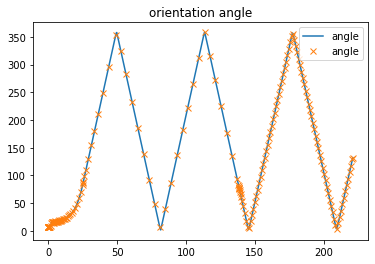

In [136]:
angle_quat = (180/np.pi)*2*np.arccos(sol.sol(t_eval)[7])
angle_m = (180/np.pi)*2*np.arccos(sol.y[7])

plt.plot(t_eval,angle_quat, '-',label='angle')
plt.plot(sol.t,angle_m,'x', label='angle')
#for t in sol.t_events:
#    plt.axvline(t,linestyle='--',color='gray')
    
plt.legend()
plt.title('orientation angle')
#plt.xlim(0,3)
#plt.ylim(0,12)

In [138]:
sol;

In [140]:
sol.y[1];

In [142]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Scatter3d(
    x=sol.y[1], y=sol.y[2], z=sol.y[3],
    marker=dict(
        size=4,
        color=sol.t,
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
))

fig.update_layout(
    width=800,
    height=700,
    autosize=False,
    scene=dict(
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=1.25,
                y=-1.25,
                z=1.25,
            )
        ),
        aspectratio = dict( x=1, y=1, z=1 ),
        aspectmode = 'auto'
    ),
)

fig.show()

In [145]:
landing_site=[]
sols = []
for i in range(50):
    
    env = Env(np.array([-5,10,0]))
    
    s1 = State(quaternion=Quaternion(1,0,0,0), env=env)
    
    s1.mass = 40*(0.95 + 0.1*np.random.rand())*u.kg
    
    sim = Simulation(r, s1)
    
    sol = sim.solve(t_span=[0,10*60])
    
    sols.append(sol)
    
    landing_site.append(sol.y[1:3,-1])

In [146]:
landing_site

[array([ 259.78380255, 1964.61207572]),
 array([ 203.22916339, 1813.91873793]),
 array([ 369.0233305 , 1498.88646239]),
 array([ 260.8581457 , 1704.74801347]),
 array([ 317.77281677, 1920.38053646]),
 array([ 182.3478273 , 1641.73576375]),
 array([ 278.85355451, 1724.56774625]),
 array([ 292.43577565, 1518.54644878]),
 array([ 277.68782533, 1621.24621243]),
 array([ 273.45214809, 1920.04712033]),
 array([ 230.57168774, 1588.5321213 ]),
 array([ 257.14805029, 1620.81078722]),
 array([ 329.64296935, 1690.22385293]),
 array([ 350.14769579, 1798.90918985]),
 array([ 289.11616965, 1563.72537634]),
 array([ 305.13260071, 1667.64791387]),
 array([ 335.29011864, 1602.08145535]),
 array([ 182.67033317, 1754.79434954]),
 array([ 395.99628912, 1586.30051447]),
 array([ 273.52045547, 1833.61242083]),
 array([ 231.21392276, 1841.23107945]),
 array([ 332.41009861, 1574.34627096]),
 array([ 188.27860595, 1627.14715241]),
 array([ 273.66381857, 1650.71819466]),
 array([ 177.87494073, 1776.3561298 ]),


In [147]:
x = [l[0] for l in landing_site]
y = [l[1] for l in landing_site]

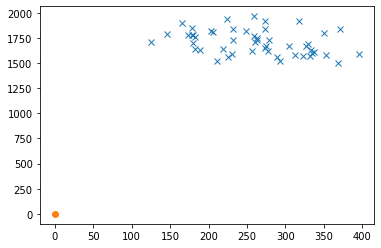

In [148]:
plt.plot(x, y,'x')
plt.plot(0,0,'o')

In [160]:
print(sum(x)/len(x))
print(sum(y)/len(y))

260.06804379014625
1708.0648977582432


In [149]:
data = [go.Scatter3d(
    x=sol.y[1], y=sol.y[2], z=sol.y[3],
    marker=dict(
        size=4,
        color=sol.t,
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
) for sol in sols]

fig = go.Figure(data=data)

fig.update_layout(
    width=800,
    height=700,
    autosize=False,
    scene=dict(
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=1.25,
                y=-1.25,
                z=1.25,
            )
        ),
        aspectratio = dict( x=1, y=1, z=1 ),
        aspectmode = 'auto'
    ),
)

fig.show()

In [150]:
origin = np.array([55+43.617/60, -4-48.667/60])

#origin = np.array([51.4983, -0.1768])

In [151]:
origin

array([55.72695   , -4.81111667])

In [152]:
R = 6371000
lat = [origin[0] + (l[1]/R)*180/np.pi for l in landing_site]
lon = [origin[1] + (l[0]/R)*180/np.pi for l in landing_site]

In [153]:
lat;

In [154]:
landing_site_radius = 3.704*1000 # meters

landing_circle_lat = [origin[0] + landing_site_radius*np.sin(th)/R*180/np.pi for th in np.linspace(0,2*np.pi)]
landing_circle_lon = [origin[1] + landing_site_radius*np.cos(th)/R*180/np.pi for th in np.linspace(0,2*np.pi)]



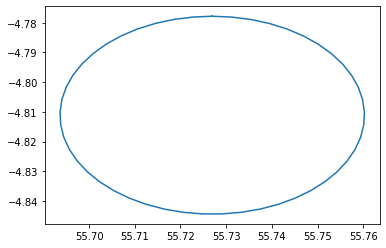

In [155]:
plt.plot(landing_circle_lat,landing_circle_lon)

In [156]:
fig = go.Figure()

data = [go.Scattermapbox(
    fill = "toself",
    lon = landing_circle_lon, lat =landing_circle_lat)
    ,
        go.Scattermapbox(lat=[origin[0]],
                  lon=[origin[1]],
                  mode="markers",
                  showlegend=False,
                  marker=dict(color="green", size=12, opacity=0.8)),
    go.Scattermapbox(lat=lat,
                  lon=lon,
                  mode="markers",
                  showlegend=False,
                  marker=dict(color="crimson", size=8, opacity=0.8))
       ]


layout = go.Layout(autosize=True,
                   mapbox_style="open-street-map",
                   mapbox= dict(zoom=12,
                                center= dict(
                                         lat=origin[0],
                                         lon=origin[1]),
                               layers = [dict(circle=dict(radius=20))]),
                    width=900,
                    height=600
)

fig = go.Figure(data=data, layout=layout)
fig.show()

In [157]:
R = 6371000
lat_path = origin[0] + (sol.y[1]/R)*180/np.pi
lon_path = origin[1] + (sol.y[2]/R)*180/np.pi


In [158]:
fig = go.Figure()

data = [go.Scattermapbox(lat=[origin[0]],
                  lon=[origin[1]],
                  mode="markers",
                  showlegend=False,
                  marker=dict(color="green", size=12, opacity=0.8))
    ] + [go.Scattermapbox(lat=origin[0] + (sol.y[2]/R)*180/np.pi,
                  lon=origin[1] + (sol.y[1]/R)*180/np.pi,
                  mode="markers",
                  showlegend=False,
                  marker=dict(color="black", size=2, opacity=0.8)) for sol in sols] + [go.Scattermapbox(lat=lat,
                  lon=lon,
                  mode="markers",
                  showlegend=False,
                  marker=dict(color="crimson", size=8, opacity=0.8))]



layout = go.Layout(autosize=True,
                   mapbox_style="open-street-map",
                   mapbox= dict(zoom=12,
                                center= dict(
                                         lat=origin[0],
                                         lon=origin[1])),
                    width=900,
                    height=600)
fig = go.Figure(data=data, layout=layout)
fig.show()